# Introduction

In [1]:
# Import required packages
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

Open `lotka_volterra_data.h5` file on notebook

In [2]:
with h5py.File('lotka_volterra_data.h5', 'r') as f:
    # Access the full dataset
    trajectories = f['trajectories'][:]
    time_points = f['time'][:]

    # Access a single trajectory
    system_id = 0 # First system

Checikng shape of the dataset, we expect trajectories to be of size $(1000 \times 100 \times 2)$, and time_points of size $(100 \times 1)$

In [3]:
print('Time points shape:',time_points.shape)
print('')
print('Trajectory shape (pray/predator):',trajectories.shape)

Time points shape: (100,)

Trajectory shape (pray/predator): (1000, 100, 2)


In [4]:

num_systems, num_time_steps, num_variables = trajectories.shape
# Create a DataFrame
df_traj = pd.DataFrame({
    "system_id": np.repeat(np.arange(num_systems), num_time_steps),  # Repeats 0-999, each 100 times
    "time_step": np.repeat(time_points[np.arange(num_time_steps)], num_systems),    # Cycles 0-99 for each system
    "prey": trajectories[:, :, 0].flatten(),  # Flatten prey values
    "predator": trajectories[:, :, 1].flatten()  # Flatten predator values
})


In [5]:
df_traj # Visualising data in dataframe format

,system_id,time_step,prey,predator
0,0,0.0,0.949917,1.040624
1,0,0.0,0.740551,0.779542
2,0,0.0,0.682246,0.564390
3,0,0.0,0.716674,0.407644
4,0,0.0,0.824511,0.300283
...,...,...,...,...
99995,999,200.0,0.901549,0.579420
99996,999,200.0,0.957527,0.539055
99997,999,200.0,1.036460,0.515615
99998,999,200.0,1.129212,0.510619


In [6]:
time_step = df_traj['time_step'].to_numpy()

print(time_step[4925])

8.080808080808081


# Part 2 (a)

Grouping prey and predator into arrays to determine the maximum value for scaling procedure.

In [7]:
prey_array = df_traj['prey'].to_numpy() # Converting to numpy array
predator_array = df_traj['predator'].to_numpy()

### 2.10 Scaling Dataset `lotka_volterra_data.h5`

As we will see in the `Table` presented below, in the original dataset we have laues that vary significantly. To standardize the numeric range, we are going to use [quantiles]( https://en.wikipedia.org/wiki/Quantile). A quantile is a value that divides a dataset into equal-sized intervals, indicating the data points below which a given percentage if observations fall. From the project instructions it is adviced to apply a simple scaling:
$$
x_t' = \frac{x_t}{\alpha}
$$
where $\alpha$ should be chosen based on the distribution of the dataset `lotka_volterra_data.h5`.

In our particular case we want most of our dataset to be in range $[0,10]$. This is coded in the [`preprocessor.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py) file, which appropriate docstrings.



#### `numpy.quantile()`

For scaling our dataset we want to use [`numpy.quantile()`](https://numpy.org/doc/2.1/reference/generated/numpy.quantile.html). The `numpy.quantile()` function calculates the quantiles of a given NumPy array. Quantiles are cut points that devide the data into intercals with equal probability. Thus `numpy.quantile()`can be used to scale our dataset dynamically, without having to worry about choosing the appropriate value for $\alpha$.

All of this is implemented in the function `scaling_operator`, which also <b>rounds</b> each datapoint using `numpy.round()`, this is set to 3 decimal places.

In [8]:
# Import class Preprocessor from src/preprocessor.py
from src.preprocessor import Preprocessor

# Set scaling_operator to function 
scaling_operator = Preprocessor.scaling_operator

Scaling data

In [9]:
trajectories_scaled, scaling_factor = scaling_operator(trajectories, 0.9, 10)
print('Scaling factor:', scaling_factor)

Scaling factor: 0.25283724


Collecting scaled data into `pandas.DataFrame` format, in particular, we want to construct a $100000\times 4$ table, (number of rows $= 1000 \times 100$). With four colums, of which three are `time_step`, `prey` and `predator`, but with an additional one `system_id` (this separates the $1000$ different systems), which will be later used to convert our timeseries data into string format.

In [10]:
num_systems_scaled, num_time_steps_scaled, num_variables_scaled = trajectories_scaled.shape

# Create a DataFrame
df_traj_scaled = pd.DataFrame({
    "system_id": np.repeat(np.arange(num_systems_scaled), num_time_steps_scaled),  # Repeats 0-999, each 100 times
    "time_step": np.repeat(time_points[np.arange(num_time_steps_scaled)], num_systems_scaled),  # Cycles 0-200 (array.shape = (100,)) for each system
    "prey": trajectories_scaled[:, :, 0].flatten(),  # Flatten prey values
    "predator": trajectories_scaled[:, :, 1].flatten()  # Flatten predator values
})

Visualising `df_traj_scaled`.

In [11]:
df_traj_scaled

,system_id,time_step,prey,predator
0,0,0.0,3.757,4.116
1,0,0.0,2.929,3.083
2,0,0.0,2.698,2.232
3,0,0.0,2.835,1.612
4,0,0.0,3.261,1.188
...,...,...,...,...
99995,999,200.0,3.566,2.292
99996,999,200.0,3.787,2.132
99997,999,200.0,4.099,2.039
99998,999,200.0,4.466,2.020


Converting `prey` and `predator` columns into array using [`pandas.DataFrame.to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html)

In [12]:
prey_array_scaled = df_traj_scaled['prey'].to_numpy() # Converting to numpy array
predator_array_scaled = df_traj_scaled['predator'].to_numpy()

Defining a function that calculates the percentage of values in an array that fall outside a given range. (This seem tedious, as we set a value for quantile in the function `scaling_operator`, e.g. $q = 0.9$, means that only $10%$ of the values will be out of our custom range. But this will be used to measure what percentage of datapoints in the original dataset is outside a specific range.)

In [13]:
def scaling_measure(arr, min_val, max_val):
    
    """
    Calculates the percentage of values in an array that fall outside a given range.

    Parameters:
    -----------
    arr : array-like
        The input numerical data.
    min_val : float
        The minimum acceptable value.
    max_val : float
        The maximum acceptable value.

    Returns:
    --------
    str
        The percentage of values outside the range, formatted as a string.
    """

    # Count values about the max range
    outside_count = np.sum((arr < min_val)|(arr > max_val))

    # Calculating the pergentage of values outside max range
    percentage_outside = (outside_count/arr.size)*100

    return f'{percentage_outside:.2f}%'

Collecting scaling information into a Table using `pandas.DataFrame`.

In [14]:
min_val = 0
max_val = 1
Table_1 = pd.DataFrame({

    'Pray': [max(prey_array), np.mean(prey_array), min(prey_array), scaling_measure(prey_array, min_val, max_val)],
    'Pray after scaling': [max(prey_array_scaled), np.mean(prey_array_scaled), min(prey_array_scaled), scaling_measure(prey_array_scaled, min_val, max_val)],
    'Predator': [max(predator_array), np.mean(predator_array), min(predator_array), scaling_measure(predator_array, min_val, max_val)],
    'Predator after scaling': [max(predator_array_scaled), np.mean(predator_array_scaled), min(predator_array_scaled), scaling_measure(predator_array_scaled, min_val, max_val)],
    
})
Table_1.index = ["Maximim Value", "Mean Value", "Minimum Value", f"Values outside the range {min_val}-{max_val}"] # Adding index for each row

 From the table below, we can observe, scaling was successful. The reason why we want to test how many data points are outside the range $[0,1]$, is due to the fact that a lot of data points in the original dataset (pre-scaling) are very small, many of order $10^{-3}$ (and smaller order $10^{-4}$), which may affect the tokenisation process.

In [15]:
Table_1

,Pray,Pray after scaling,Predator,Predator after scaling
Maximim Value,13.740113,54.344002,4.76849,18.860001
Mean Value,1.698114,6.71623,0.569606,2.252858
Minimum Value,0.002077,0.008,0.000037,0.0
Values outside the range 0-1,63.11%,93.82%,12.21%,77.31%


Looking at the last row, we can see that we have a major improvement for both `prey` and `predator` categories, the percentage of values outside the range $[0,1]$ has increased in `prey` by ~ $30\%$ and `predator` by ~ $65\%$. Thus, scaling was successful. Now we can proceed with the next step, i.e. converting the scaled dataset to strings, for compatibility with [Qwen2.5]( https://github.com/QwenLM/Qwen2.5).

### 2.11 Loading Qwen2.5

Below a short demonstration on how to use `load_qwen()` from `src.qwen`.

In [16]:
from src.qwen import load_qwen # Import load_qwen
model, tokenizer = load_qwen() # set model = model and tokeinzer = tokenizer

/root/Document/Term2/M2/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-15 14:55:04.965622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742050505.131670    4443 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742050505.177932    4443 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 14:55:05.602096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance

Trying with examples provided at the end of project instructions, see [LLMTIME Preprocessing Scheme](https://github.com/MatteoMancini01/M2_Cw/blob/main/instructions/main.pdf).

In [17]:
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0])
print('')
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0])

[16, 13, 17, 18]

[16, 659, 220, 17, 220, 18]


Trying to tokenise $[0.25,1.50;0.27,1.47;0.31,1.42]$

In [18]:
print(tokenizer("0.25,1.50;0.27,1.47;0.31,1.42", return_tensors='pt')["input_ids"].tolist()[0])

[15, 13, 17, 20, 11, 16, 13, 20, 15, 26, 15, 13, 17, 22, 11, 16, 13, 19, 22, 26, 15, 13, 18, 16, 11, 16, 13, 19, 17]


Example of how `load_qwen()` works!

In [19]:
text = 'Hello, world' # Define input text
input_ids = tokenizer(text, return_tensors='pt').input_ids # Tokenize text 
output = model.generate(input_ids, max_length = 50) # Generate output

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


From the above code line 3 `output`, the variable `max_length` determines how many more words will the model predict when inputing text, e.g. `text = Hello, world`, as we can see from the below output.

In [20]:
output

tensor([[ 9707,    11,  1879,     0,  1096,   374,   264,  4285, 13027,  5316,
           429, 15804,   279,  8794,   315,   264,  1034,   323, 23473,   700,
          1817,  1555,   304,  9931,  1973,    13,  5692,   594,  1246,   498,
           646,   653,   432,  1447, 73594, 12669,   198,     2,  5264,   279,
          1034,   304,  1349,  3856,   198,  4197,  1787,   492,  8404,  3909]])

From the above tensor we recognise that the first 3 tokens are related to our text, the rest of the tokens is predicted text determined from the model, as we will see below when decoding `output`.

In [21]:
print(tokenizer.decode(output[0], skip_special_tokens=True)) # Decoding output

Hello, world! This is a simple Python script that reads the contents of a file and prints out each line in reverse order. Here's how you can do it:

```python
# Open the file in read mode
with open('filename.txt


### 2.12 Converting Scaled Dataset into Strings

We now have seen how tokenisation for text works! There is a small issue, Qwen2.5 is only designed to convert text, i.e. strings in Python, to tokens, while our dataset is a timeseries composed of 2 variables prey and predator over a time series of size 100, this is repated for a 1000 samples. Thus, before we proceed with tokenisation, we require to convert the time series data into sets of strings. To do so we are going to define a fucntion `array_to_string(data)`, and a function to convert string to array `sring_to_array(formatted_string)` (both functions are in [preprocessor.py](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py)).

⚠ Note: The function `array_to_string` is specifically designed for the dataset `lotka_volterra_data.h5`, in particular after converting `trajectories` into a `panda.DataFrame` format, with columns `system_id` (labeling each system from 0 to 999), columns `prey` and `predator`, each  displaying 100 data points for every `system_id`.

In [22]:
from src.preprocessor import Preprocessor

array_to_string = Preprocessor.array_to_string # Importing array_to_string(data) to convert timeseries to string
string_to_array = Preprocessor.string_to_array # Importing string_to_array(formatted_string) to convert strings back to arrays

traject_scaled_string = array_to_string(df_traj_scaled) # Converting df_traj_scaled into string format

Checking result post-conversion

In [23]:
print(traject_scaled_string) # Print output

system_id
0      3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.61...
1      3.842,3.977;4.266,3.25;4.987,2.715;6.019,2.346...
2      4.245,4.401;3.378,3.56;3.038,2.801;3.04,2.187;...
3      4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.28...
4      3.276,3.167;3.533,2.247;4.089,1.611;4.943,1.17...
                             ...                        
995    3.918,4.625;2.139,3.254;1.521,2.104;1.327,1.32...
996    3.595,4.653;2.249,3.797;1.681,2.896;1.484,2.15...
997    4.465,4.433;4.055,4.03;3.9,3.615;3.981,3.237;4...
998    4.476,4.017;3.167,3.167;2.564,2.341;2.362,1.68...
999    4.035,4.489;3.028,4.1;2.481,3.453;2.277,2.794;...
Length: 1000, dtype: object


We also want to test the function `string_to_array`, this is done below for the first `system_id` string data format, i.e. `system_id` $ = 0$.

In [24]:
print(string_to_array(traject_scaled_string[0]))

[[ 3.757  4.116]
 [ 2.929  3.083]
 [ 2.698  2.232]
 [ 2.835  1.612]
 [ 3.261  1.188]
 [ 3.973  0.909]
 [ 4.995  0.736]
 [ 6.35   0.642]
 [ 8.033  0.611]
 [ 9.978  0.64 ]
 [12.027  0.741]
 [13.915  0.938]
 [15.283  1.271]
 [15.732  1.785]
 [14.933  2.492]
 [12.876  3.282]
 [10.089  3.882]
 [ 7.451  4.015]
 [ 5.574  3.666]
 [ 4.52   3.066]
 [ 4.08   2.448]
 [ 4.068  1.929]
 [ 4.385  1.536]
 [ 4.991  1.259]
 [ 5.869  1.081]
 [ 7.002  0.986]
 [ 8.344  0.963]
 [ 9.801  1.013]
 [11.212  1.145]
 [12.356  1.373]
 [12.979  1.715]
 [12.864  2.165]
 [11.941  2.672]
 [10.379  3.118]
 [ 8.59   3.351]
 [ 7.014  3.296]
 [ 5.897  3.004]
 [ 5.265  2.6  ]
 [ 5.044  2.193]
 [ 5.154  1.845]
 [ 5.539  1.577]
 [ 6.165  1.389]
 [ 6.997  1.277]
 [ 7.985  1.235]
 [ 9.047  1.263]
 [10.065  1.363]
 [10.892  1.539]
 [11.366  1.792]
 [11.36   2.108]
 [10.829  2.451]
 [ 9.87   2.75 ]
 [ 8.698  2.927]
 [ 7.569  2.934]
 [ 6.673  2.781]
 [ 6.095  2.527]
 [ 5.834  2.238]
 [ 5.856  1.969]
 [ 6.119  1.748]
 [ 6.586  1.58

As we can observe from the above output, we successfully converted string back to array.

### 2.13 Tokenisation 

We provided few basic examples on how to use `load_qwen()` in section 2.11, with some text and numbers (string form). We now want to proceed and tokenise our data, to achieve this, we designed a function for our particular needs that uses `model, tokenizer = load_qwen()`.


In [25]:
from src.qwen import tokenize_time_series


In [26]:
tokenised_data = tokenize_time_series(traject_scaled_string)

Visualising data before tokenisation:

In [27]:
traject_scaled_string

system_id
0      3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.61...
1      3.842,3.977;4.266,3.25;4.987,2.715;6.019,2.346...
2      4.245,4.401;3.378,3.56;3.038,2.801;3.04,2.187;...
3      4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.28...
4      3.276,3.167;3.533,2.247;4.089,1.611;4.943,1.17...
                             ...                        
995    3.918,4.625;2.139,3.254;1.521,2.104;1.327,1.32...
996    3.595,4.653;2.249,3.797;1.681,2.896;1.484,2.15...
997    4.465,4.433;4.055,4.03;3.9,3.615;3.981,3.237;4...
998    4.476,4.017;3.167,3.167;2.564,2.341;2.362,1.68...
999    4.035,4.489;3.028,4.1;2.481,3.453;2.277,2.794;...
Length: 1000, dtype: object

After tokenisation:

In [28]:
tokenised_data

system_id
0      [input_ids, attention_mask]
1      [input_ids, attention_mask]
2      [input_ids, attention_mask]
3      [input_ids, attention_mask]
4      [input_ids, attention_mask]
                  ...             
995    [input_ids, attention_mask]
996    [input_ids, attention_mask]
997    [input_ids, attention_mask]
998    [input_ids, attention_mask]
999    [input_ids, attention_mask]
Length: 1000, dtype: object

Clsoer look at two examples:

In [29]:
# Print tokenised output for the first system
print('Two examples of tokens from tokenised_data:')
print('')
print('Preprocessed data:')
print(traject_scaled_string[3])
print('')
print('After tokenisation:')
print(tokenised_data.iloc[3]["input_ids"].squeeze().tolist())  # Tokenised tensor
print('Length of the above token:',len(tokenised_data.iloc[3]["input_ids"].squeeze().tolist()))  # Tokenised tensor
print('')
print('')
print('Preprocessed data:')
print(traject_scaled_string[990])
print('')
print('After tokenisation:')
print(tokenised_data.iloc[990]["input_ids"].squeeze().tolist())
print('Length of the above token:',len(tokenised_data.iloc[990]["input_ids"].squeeze().tolist()))


Two examples of tokens from tokenised_data:

Preprocessed data:
4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.281;1.064,2.682;0.985,2.167;1.001,1.747;1.097,1.415;1.276,1.159;1.55,0.967;1.943,0.829;2.482,0.737;3.2,0.687;4.123,0.678;5.257,0.716;6.562,0.815;7.924,0.998;9.13,1.307;9.86,1.792;9.749,2.494;8.564,3.374;6.523,4.207;4.348,4.651;2.719,4.538;1.766,4.031;1.271,3.387;1.035,2.764;0.945,2.226;0.951,1.787;1.036,1.44;1.201,1.173;1.456,0.973;1.825,0.827;2.337,0.728;3.024,0.67;3.917,0.652;5.029,0.68;6.335,0.763;7.739,0.925;9.045,1.203;9.947,1.649;10.062,2.316;9.091,3.192;7.12,4.099;4.814,4.678;2.985,4.677;1.89,4.211;1.314,3.563;1.034,2.913;0.918,2.344;0.904,1.876;0.969,1.505;1.11,1.218;1.338,1.001;1.671,0.841;2.137,0.73;2.772,0.661;3.609,0.631;4.669,0.644;5.946,0.706;7.369,0.838;8.777,1.073;9.892,1.46;10.333,2.058;9.727,2.895;7.978,3.859;5.6,4.616;3.489,4.82;2.134,4.464;1.414,3.824;1.061,3.142;0.904,2.528;0.861,2.019;0.9,1.612;1.013,1.295;1.205,1.054;1.493,0.875;1.904,0.747;2.469,0.663;3.22

Summary of <b>Part 2 (a)</b>:

- Load the predator-prey dataset from the `lotka_volterra_data.h5` file.
- Applied the LLMTIME preprocessing scheme, this includes:
    - Scale the numaric values using the fucntion ` scaling_operator` (in file `preprocessor.py`).
    - Round the values to a fixed number of decimal places (we have used 3 d.p.).
    - Converted the sequences into formatted strings using:
        - Commas to separate variables at each timestep.
        - Semicolons to separate different timesteps.
        - Collection of every system.
- Tokenised the processed sequences using the Qwen2.5 tokeniser.  

# Part 2 (b)

text = 'Hello, world' # Define input text
input_ids = tokenizer(text, return_tensors='pt').input_ids # Tokenize text 
output = model.generate(input_ids, max_length = 50) # Generate output

print(tokenizer.decode(output[0], skip_special_tokens=True)) # Decoding output


In [61]:
input_ids = tokenised_data[0].input_ids
output = model.generate(input_ids, max_length = 2400)


In [62]:
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

In [65]:
# Extract input_ids from the first tokenized sample
input_ids = tokenised_data[0].input_ids

# Ensure input_ids is in the correct shape
input_ids = input_ids.unsqueeze(0) if input_ids.dim() == 1 else input_ids  # Add batch dim if needed

# Generate predictions
output = model.generate(input_ids, max_length=2400)

# Remove input tokens (only keep new tokens)
predicted_tokens = output[:, input_ids.shape[1]:]  # Slice output AFTER input length

# Decode only the predicted part
decoded_output = tokenizer.decode(predicted_tokens[0], skip_special_tokens=True)

print("Predicted sequence:", decoded_output)


Predicted sequence: ;9.24,2.229;9.192,2.358;9.121,2.475;9.137,2.578;9.157,2.684;9.148,2.79;9.158,2.893;9.154,2.997;9.161,3.093;9.168,3.188;9.172,3.285;9.175,3.382;9.178,3.478;9.179,3.574;9.179,3.672;9.181,3.778;9.183,3.885;9.185,3.99;9.187,4.095;9.188,4.195;9.188,4.295;9.188,4.395;9.188,4.495;9.188,4.595;9.188,4.695;9.188,4.795;9.188,4.895;9.188,4.995;9.188,5.095;9.188,5.195;9.188,5.295;9.188,5.395;9.188,5.495;9.188,5.595;9.188,5.695;9.188,5.795;9.188,5.895;9.188,5.995;9.188,6.095;9.188,6.195;9.188,6.295;9.188,6.395;9.188,6.495;9.188,6.595;9.188,6.695;9.188,6.795;9.188,6.895;9.188,6.995;9.188,7.095;9.188,7.195;9.188,7.295;9.188,7.395;9.188,7.495;9.188,7.595;9.188,7.695;9.188,7.795;9.188,7.895;9.188,7.995;9.188,8.095;9.188,8.195;9.188,8.295;9.188,8.395;9.188,8.495;9.188,8.595;9.188,8.695;9.188,8.795;9.188,8.895;9.188,8.995;9.188,9.095;9.188,9.195;9.188,9.295;9.188,9.395;9.188,9.495;9.188,9.595;9.188,9.695;9.188,9.795;9.188,9.895;9.188,9.995;9.188,10.095;9.188,10.195;9.188,10.295;9.188,1

In [66]:
decoded_output

';9.24,2.229;9.192,2.358;9.121,2.475;9.137,2.578;9.157,2.684;9.148,2.79;9.158,2.893;9.154,2.997;9.161,3.093;9.168,3.188;9.172,3.285;9.175,3.382;9.178,3.478;9.179,3.574;9.179,3.672;9.181,3.778;9.183,3.885;9.185,3.99;9.187,4.095;9.188,4.195;9.188,4.295;9.188,4.395;9.188,4.495;9.188,4.595;9.188,4.695;9.188,4.795;9.188,4.895;9.188,4.995;9.188,5.095;9.188,5.195;9.188,5.295;9.188,5.395;9.188,5.495;9.188,5.595;9.188,5.695;9.188,5.795;9.188,5.895;9.188,5.995;9.188,6.095;9.188,6.195;9.188,6.295;9.188,6.395;9.188,6.495;9.188,6.595;9.188,6.695;9.188,6.795;9.188,6.895;9.188,6.995;9.188,7.095;9.188,7.195;9.188,7.295;9.188,7.395;9.188,7.495;9.188,7.595;9.188,7.695;9.188,7.795;9.188,7.895;9.188,7.995;9.188,8.095;9.188,8.195;9.188,8.295;9.188,8.395;9.188,8.495;9.188,8.595;9.188,8.695;9.188,8.795;9.188,8.895;9.188,8.995;9.188,9.095;9.188,9.195;9.188,9.295;9.188,9.395;9.188,9.495;9.188,9.595;9.188,9.695;9.188,9.795;9.188,9.895;9.188,9.995;9.188,10.095;9.188,10.195;9.188,10.295;9.188,10.395;9.188,10.495;

In [57]:
print(type(decoded_output))
print(type(traject_scaled_string[0]))

<class 'str'>
<class 'str'>


In [ ]:
import numpy as np

def string_to_array(formatted_string):
    """
    Converts a formatted string of prey/predator values back into a NumPy array.
    Ensures that only complete (prey, predator) pairs are included while
    ignoring invalid leading/trailing semicolons or incomplete entries.

    Parameters:
    -----------
    formatted_string : str
        A string with values formatted as "prey, predator; prey, predator; ...".

    Returns:
    --------
    np.ndarray
        A NumPy array of shape (N, 2), where each row represents a timestep 
        with prey and predator values.
    """

    # Remove any leading or trailing semicolons
    formatted_string = formatted_string.strip(";")

    # Split the string by semicolons to get each "prey, predator" pair
    pairs = formatted_string.split(";")

    # Ensure no empty strings and filter out invalid entries
    cleaned_pairs = []
    for pair in pairs:
        values = pair.split(",")  # Split each entry into numbers
        values = [v.strip() for v in values if v.strip()]  # Remove extra spaces & filter empty

        if len(values) == 2:  # Only keep valid pairs
            try:
                cleaned_pairs.append(list(map(float, values)))  # Convert to float
            except ValueError as e:
                print(f"Skipping invalid entry: {pair} → {e}")  # Debugging info

    # Convert the cleaned list into a NumPy array
    return np.array(cleaned_pairs)


[[3.757 4.116]
 [2.929 3.083]]
(2, 2)


In [77]:
decoded_to_number = string_to_array(decoded_output)
decoded_to_number

array([[ 9.24 ,  2.229],
       [ 9.192,  2.358],
       [ 9.121,  2.475],
       [ 9.137,  2.578],
       [ 9.157,  2.684],
       [ 9.148,  2.79 ],
       [ 9.158,  2.893],
       [ 9.154,  2.997],
       [ 9.161,  3.093],
       [ 9.168,  3.188],
       [ 9.172,  3.285],
       [ 9.175,  3.382],
       [ 9.178,  3.478],
       [ 9.179,  3.574],
       [ 9.179,  3.672],
       [ 9.181,  3.778],
       [ 9.183,  3.885],
       [ 9.185,  3.99 ],
       [ 9.187,  4.095],
       [ 9.188,  4.195],
       [ 9.188,  4.295],
       [ 9.188,  4.395],
       [ 9.188,  4.495],
       [ 9.188,  4.595],
       [ 9.188,  4.695],
       [ 9.188,  4.795],
       [ 9.188,  4.895],
       [ 9.188,  4.995],
       [ 9.188,  5.095],
       [ 9.188,  5.195],
       [ 9.188,  5.295],
       [ 9.188,  5.395],
       [ 9.188,  5.495],
       [ 9.188,  5.595],
       [ 9.188,  5.695],
       [ 9.188,  5.795],
       [ 9.188,  5.895],
       [ 9.188,  5.995],
       [ 9.188,  6.095],
       [ 9.188,  6.195],


In [80]:
traj_0 = string_to_array(traject_scaled_string[0])

In [87]:
print(decoded_to_number.shape)
print(traj_0.shape)

(98, 2)
(100, 2)


In [78]:
time_step

array([  0.,   0.,   0., ..., 200., 200., 200.])

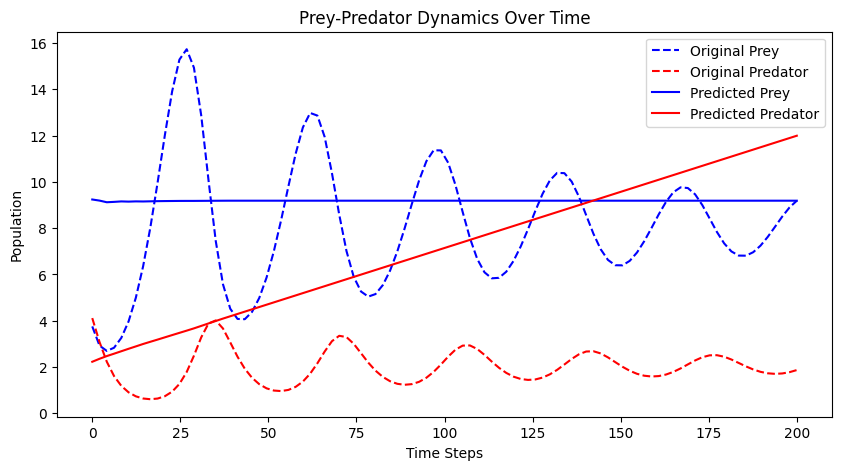

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure `decoded_to_number` is trimmed to match `traj_0`
min_length = min(len(traj_0), len(decoded_to_number))

# Trim both arrays to the same length
time_step = np.linspace(0, 200, min_length)  # Adjust time range
prey_values = traj_0[:min_length, 0]  # Trim original prey
predator_values = traj_0[:min_length, 1]  # Trim original predator

predict_prey = decoded_to_number[:min_length, 0]  # Trim predicted prey
predict_predator = decoded_to_number[:min_length, 1]  # Trim predicted predator

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(time_step, prey_values, label="Original Prey", color="blue", linestyle="dashed")
plt.plot(time_step, predator_values, label="Original Predator", color="red", linestyle="dashed")

plt.plot(time_step, predict_prey, label="Predicted Prey", color="blue")
plt.plot(time_step, predict_predator, label="Predicted Predator", color="red")

# Labels and Title
plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.title("Prey-Predator Dynamics Over Time")
plt.legend()

# Show the plot
plt.show()
